In [ ]:
!pip install gdown
import gdown

# File ID extracted from the link
file_id = "1dpXYL4Ghr2OCSObh9HK5z3XnKO0_kFgj"
destination = "dataset.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


!unzip -o dataset.zip -d dataset


In [2]:
import os

directory = "/content/dataset/train_images"

for root, dirs, files in os.walk(directory):
    level = root.replace(directory, "").count(os.sep)
    indent = " " * (4 * level)
    print(f"{indent}{os.path.basename(root)}/")



train_images/
    bacterial_leaf_blight/
    blast/
    downy_mildew/
    dead_heart/
    bacterial_leaf_streak/
    bacterial_panicle_blight/
    tungro/
    hispa/
    brown_spot/
    normal/


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import os

# Directories
train_dir = "/content/dataset/train_images"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Splitting dataset
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

# Class Weights to handle imbalance
class_counts = train_generator.classes
class_weights = {i: len(class_counts) / np.sum(class_counts == i) for i in np.unique(class_counts)}

# Load VGG19 (without top layers, keeping weights from ImageNet)
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers[:15]:  # Unfreezing deeper layers for fine-tuning
    layer.trainable = False

# Custom Model
x = Flatten()(vgg.output)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)

# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)

# Save Model
model.save("vgg19_rice_disease_model.h5")


Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 204s 705ms/step - accuracy: 0.1995 - loss: 25.2569 - val_accuracy: 0.2147 - val_loss: 5.4509 - learning_rate: 1.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 163s 624ms/step - accuracy: 0.3860 - loss: 17.3119 - val_accuracy: 0.4526 - val_loss: 2.0031 - learning_rate: 1.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 202s 625ms/step - accuracy: 0.5085 - loss: 14.1172 - val_accuracy: 0.4396 - val_loss: 2.1201 - learning_rate: 1.0000e-04
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 628ms/step - accuracy: 0.6217 - loss: 11.0852 - val_accuracy: 0.4993 - val_loss: 2.0188 - learning_rate: 1.0000e-04
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 168s 645ms/step - accuracy: 0.6947 - loss: 9.2589 - val_accuracy: 0.6740 - val_loss: 1.3238 - learning_rate: 1.0000e-04
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 637ms/step - accuracy: 0.7481 - loss: 7.7445 - val_accuracy: 0.7005 - val_loss: 1.3103 - learning_rate: 1.0000e-04
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━

code for storing training history

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import os

# Directories
train_dir = "/content/dataset/train_images"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Splitting dataset
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

# Class Weights to handle imbalance
class_counts = train_generator.classes
class_weights = {i: len(class_counts) / np.sum(class_counts == i) for i in np.unique(class_counts)}

# Load VGG19 (without top layers, keeping weights from ImageNet)
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers[:15]:  # Unfreezing deeper layers for fine-tuning
    layer.trainable = False

# Custom Model
x = Flatten()(vgg.output)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)

# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model
history =  model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)

# Save Model
model.save("vgg19_rice_disease_model.h5")


Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 212s 726ms/step - accuracy: 0.1775 - loss: 26.5475 - val_accuracy: 0.0347 - val_loss: 8.7135 - learning_rate: 1.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 165s 632ms/step - accuracy: 0.3532 - loss: 18.3522 - val_accuracy: 0.3885 - val_loss: 2.6425 - learning_rate: 1.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 626ms/step - accuracy: 0.5033 - loss: 13.8870 - val_accuracy: 0.4237 - val_loss: 2.1723 - learning_rate: 1.0000e-04
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 163s 624ms/step - accuracy: 0.6179 - loss: 11.2086 - val_accuracy: 0.4945 - val_loss: 2.0131 - learning_rate: 1.0000e-04
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 628ms/step - accuracy: 0.6867 - loss: 9.3364 - val_accuracy: 0.6519 - val_loss: 1.4454 - learning_rate: 1.0000e-04
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 626ms/step - accuracy: 0.7374 - loss: 7.6990 - val_accuracy: 0.6582 - val_loss: 1.4531 - learning_rate: 1.0000e-04
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━

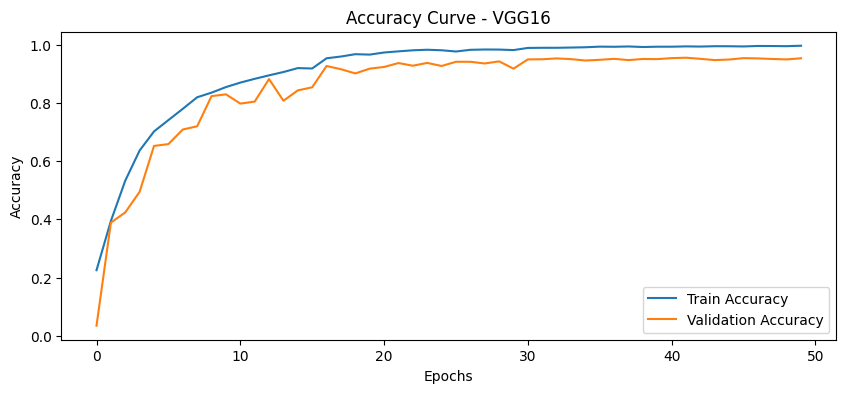

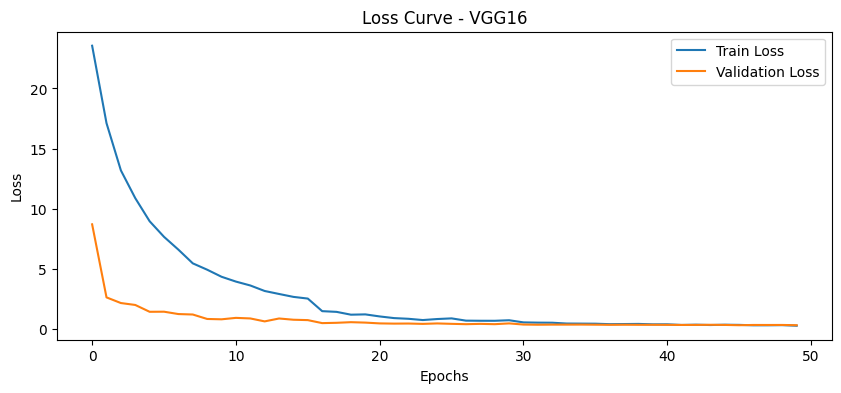

In [7]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 551ms/step - accuracy: 0.9522 - loss: 0.3508
Validation Loss: 0.3370
Validation Accuracy: 0.9543


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9364 - loss: 0.4292
Test Loss: 0.3232, Test Accuracy: 0.9567
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step


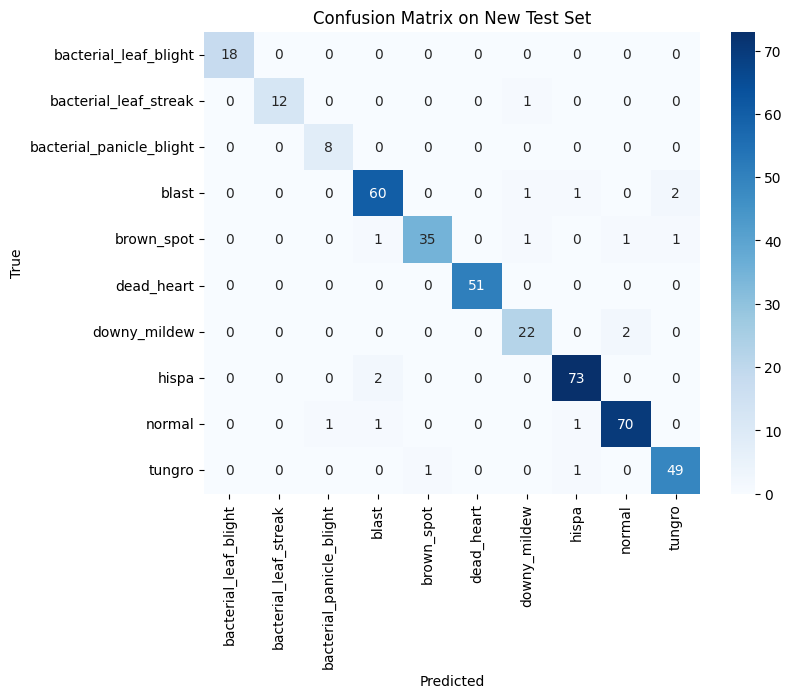

Classification Report on New Test Set:
                           precision    recall  f1-score   support

   bacterial_leaf_blight       1.00      1.00      1.00        18
   bacterial_leaf_streak       1.00      0.92      0.96        13
bacterial_panicle_blight       0.89      1.00      0.94         8
                   blast       0.94      0.94      0.94        64
              brown_spot       0.97      0.90      0.93        39
              dead_heart       1.00      1.00      1.00        51
            downy_mildew       0.88      0.92      0.90        24
                   hispa       0.96      0.97      0.97        75
                  normal       0.96      0.96      0.96        73
                  tungro       0.94      0.96      0.95        51

                accuracy                           0.96       416
               macro avg       0.95      0.96      0.95       416
            weighted avg       0.96      0.96      0.96       416



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Extract validation data from generator
val_images, val_labels = [], []
for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    val_images.append(x_batch)
    val_labels.append(y_batch)

# Convert to numpy arrays
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Convert one-hot labels to class indices
y_true = np.argmax(val_labels, axis=1)

# Split into validation and test sets (20% test set)
X_val, X_test, y_val, y_test = train_test_split(val_images, val_labels, test_size=0.2, random_state=42)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Make Predictions on the new test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot back to class indices

# Generate and plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Print classification report
print("Classification Report on Test Set:\n", classification_report(y_test_classes, y_pred_classes, target_names=train_generator.class_indices.keys()))
